In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

In [2]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('../GVR Historical Data.csv')

In [3]:
# convert date field from string to Date format and make it index
def tranformData(df: pd.DataFrame):
  df['Date'] = pd.to_datetime(df.Date, format='%m/%d/%Y')
  df['Price'] = df['Price'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['Open'] = df['Open'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['High'] = df['High'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['Low'] = df['Low'].astype(str).apply(lambda x: float(x.replace(',', '')))
  def convert_to_number(x):
      if 'M' in x:
          return float(x.replace('M', '')) * 1000000
      elif 'K' in x:
          return float(x.replace('K', '')) * 1000
      else:
          return float(x)
  df['Vol.'] = df['Vol.'].apply(convert_to_number)
  df['Change %'] = df['Change %'].apply(lambda x: float(x.strip('%'))/100)

In [4]:
tranformData(df)
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2023-06-02,18900.0,18950.0,19000.0,18600.0,2720000.0,0.0053
1,2023-06-01,18800.0,18350.0,18900.0,18100.0,4250000.0,0.0330
2,2023-05-31,18200.0,18450.0,18450.0,18000.0,3140000.0,-0.0109
3,2023-05-30,18400.0,18300.0,18500.0,17850.0,4580000.0,0.0110
4,2023-05-29,18200.0,17200.0,18200.0,17050.0,6080000.0,0.0581
...,...,...,...,...,...,...,...
1287,2018-03-28,11327.0,10736.0,11622.0,10637.0,139800.0,0.0550
1288,2018-03-27,10736.0,10637.0,10834.0,10342.0,52200.0,0.0583
1289,2018-03-26,10145.0,10046.0,10342.0,10046.0,267800.0,-0.0190
1290,2018-03-23,10342.0,10440.0,10440.0,9849.0,111800.0,-0.0367


In [5]:
df=df.sort_values(['Date'], ascending=[True])
df = df.reset_index(drop=True)
df1=df.reset_index()['Price']

In [6]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [7]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [8]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [9]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [10]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [11]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [12]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 [==============================] - 2s 60ms/step - loss: 0.0467 - val_loss: 0.0135
Epoch 2/100
13/13 [==============================] - 0s 30ms/step - loss: 0.0116 - val_loss: 0.0033
Epoch 3/100
13/13 [==============================] - 0s 30ms/step - loss: 0.0023 - val_loss: 0.0028
Epoch 4/100
13/13 [==============================] - 0s 31ms/step - loss: 9.9947e-04 - val_loss: 0.0015
Epoch 5/100
13/13 [==============================] - 0s 30ms/step - loss: 8.6169e-04 - val_loss: 0.0019
Epoch 6/100
13/13 [==============================] - 0s 31ms/step - loss: 7.0046e-04 - val_loss: 0.0016
Epoch 7/100
13/13 [==============================] - 0s 36ms/step - loss: 6.8106e-04 - val_loss: 0.0015
Epoch 8/100
13/13 [==============================] - 0s 30ms/step - loss: 6.4900e-04 - val_loss: 0.0016
Epoch 9/100
13/13 [==============================] - 0s 31ms/step - loss: 6.4334e-04 - val_loss: 0.0013
Epoch 10/100
13/13 [==============================] - 0s 29ms/step - loss: 6

In [13]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

1/1 [==============================] - 0s 28ms/step


In [14]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [15]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 16534.86757541264
Testing RMSE: 23452.455215090802


In [17]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=70
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.3646743]
71
[0.3646743]
72
[0.3646743]
73
[0.3646743]
74
[0.3646743]
75
[0.3646743]
76
[0.3646743]
77
[0.3646743]
78
[0.3646743]
79
[0.3646743]
80
[0.3646743]
81
[0.3646743]
82
[0.3646743]
83
[0.3646743]
84
[0.3646743]
85
[0.3646743]
86
[0.3646743]
87
[0.3646743]
88
[0.3646743]
89
[0.3646743]
90
[0.3646743]
91
[0.3646743]
92
[0.3646743]
93
[0.3646743]
94
[0.3646743]
95
[0.3646743]
96
[0.3646743]
97
[0.3646743]
98
[0.3646743]
99
[0.3646743]
100


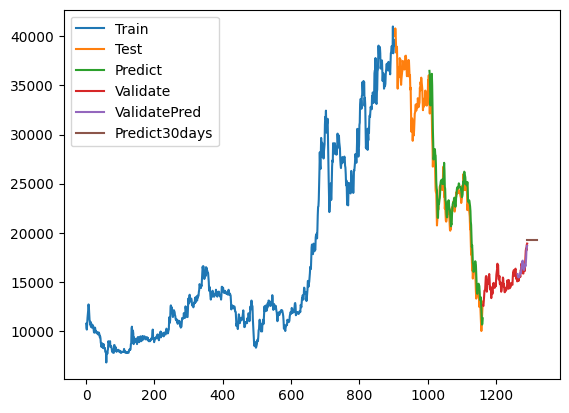

In [18]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()